In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

from data import PiDataset
from model import Generator, create_look_ahead_mask

In [2]:
# load data

X = np.load('../pi_xs.npy')
Y = np.load('../pi_ys.npy')
image_array = np.array(Image.open('../sparse_pi_colored.jpg'))
rgb_values = image_array[X, Y]

In [3]:
# set hyperparameters

num_layers = 18
embedding_dim = 64
hidden_size = 64
num_heads = 8
num_items_pos = 300
num_items_color = 256
num_items_out = [300, 300, 256, 256]
model = Generator(
    num_items_pos, num_items_color, num_items_out, num_layers=num_layers,
    embedding_dim=embedding_dim, hidden_size=hidden_size, num_heads=num_heads)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

attention_mask = create_look_ahead_mask(5)

pi_dataset = PiDataset(X, Y, rgb_values, embedding_dim=embedding_dim, device='cpu')
pi_loader = torch.utils.data.DataLoader(pi_dataset, batch_size=64, shuffle=True)

In [ ]:
for epoch in range(epochs):
    model.train()

    for i, batch in enumerate(tqdm(pi_loader)):
        noises, data = batch
        inputs = torch.cat([torch.tensor([model.BOS]*data.shape[0]).view(-1, 1), data[:, :-1]], axis=1)
        logits = model(inputs, noises, None, None, attention_mask)
        loss = 0
        for i, l in enumerate(logits):
            loss += criterion(l, data[:, i])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch {epoch}: loss: {loss.item()}')

In [5]:
# source data
p_data = np.concatenate(
    [X.reshape((-1, 1)), Y.reshape((-1, 1)), rgb_values],
    axis=1
)

# generated data
q_data = model.generate(X.shape[0])

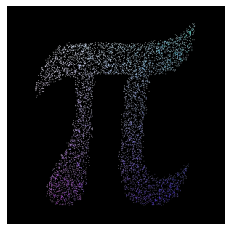

In [6]:
# source image
img_data = np.zeros((300, 300, 3), dtype=np.uint8)
img_data[p_data[:, 0], p_data[:, 1]] = p_data[:, 2:]
plt.axis('off')
plt.imshow(Image.fromarray(img_data))

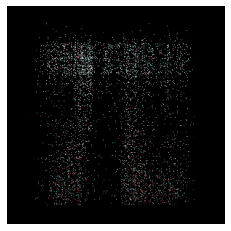

In [7]:
# generated image
img_data = np.zeros((300, 300, 3), dtype=np.uint8)
img_data[q_data[:, 0], q_data[:, 1]] = q_data[:, 2:]
plt.axis('off')
plt.imshow(Image.fromarray(img_data))